---

Hi **Michael** and **Dan**,

As planned, we have tested the efficacy of **A deaminase** on templates with **methyl-A (meA)** modifications.

## MiSeq data location

```text
/mnt/wigstore3/data/checkpointcharlie2/inessa/250707_M06142_0497_000000000-M2RFJ/Alignment_1/20250708_193955/Fastq
```

## FASTQ files to inspect

* `DB1_S3_L001_R1_001.fastq.gz`
* `DB1_S3_L001_R2_001.fastq.gz`
* `DB2_S4_L001_R1_001.fastq.gz`
* `DB2_S4_L001_R2_001.fastq.gz`
* `DB3_S5_L001_R1_001.fastq.gz`
* `DB3_S5_L001_R2_001.fastq.gz`
* `DB4_S6_L001_R1_001.fastq.gz`
* `DB4_S6_L001_R2_001.fastq.gz`
* `DB5_S7_L001_R1_001.fastq.gz`
* `DB5_S7_L001_R2_001.fastq.gz`
* `DB6_S8_L001_R1_001.fastq.gz`
* `DB6_S8_L001_R2_001.fastq.gz`

## Template information

### DB1 & DB2 (Control – **no meA**)

```text
TTGCTTGGTGCTGGTNNNNNNNNNNNNNNNCCAACTGATCTTCAGCATCTAAAAAAAAAAAAAAATTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGC
```

### DB3 & DB4 (**contains meA**)

```text
TTGCTTGGTGCTGGTNNNNNNNNNNNNNNNCCAACTGATCTTCAGCATCTAAAAAAAAAAAAAAATTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGC
```

### DB5 & DB6 (**meA with alternate modification patterns**)

```text
TTGCTTGGTGCTGGTNNNNNNNNNNNNNNNCCAACTGATCTTCAGCATCTAAAAAAAAAAAAAAATTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGC
```

> **Note:** *meA should **not** be converted to **G**.*

### Read structure

```
read 1: ""|A|TG|GAC + N(15, copy tag) + AGCCAGGAGACAGAGC + TCATGTTTAACGCAGGTGAA + T(15) + AGATGCTGAAGATCAGTTGG + N(15, template tag)

read 2: ""|G|CA|TGT + GTTGCTTGGTGCTGGT + N(15, template tag) + CCAACTGATCTTCAGCATCT + A(15) + TTCACCTGCGTTAAACATGAGCTCTGTCTCCTGGCT + N(15, copy tag)
```

Both meA-containing templates also include flanking **meA** modifications, which should clarify conversion patterns.

## Library-prep procedure

1. **A-conversion**
2. **15 cycles** of linear amplification
3. **1 cycle** linear extension to create dsDNA
4. Final **PCR** to generate libraries

Let me know if you need further information or clarification.

Thanks,
**Zihua**

The marking of the meA were lost in the conversion to markdown. 
Here, they are shown as "X".


```text
TTGCTTGGTGCTGGT NNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AAAAAAAAAAAAAAA TTCACCTGCG TTAAACATGA GCTCTGTCTC CTGGC
TTGCTTGGTGCTGGT NNNNNNNNNNNNNNN CCAACTGXTCTTCAGCATCT AAXAAAXAAAXAAXA TTCACCTGCG TTXAACATGA GCTCTGTCTC CTGGC
TTGCTTGGTGCTGGT NNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AXAAAXXXAAAXXAA TTCACCTGCG TTAAACATGA GCTCTGTCTC CTGGC
```

In [8]:

# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import re
from collections import defaultdict
import yaml
from read_break.parser import ReadParser
from read_break.logic import flatten_dot
from read_break.io import FastqReader
import pandas as pd
import numpy as np



root_dir = Path(os.getcwd()).parent
root_dir

data_dir = Path( r"Z:\mnt\wigstore3\data\checkpointcharlie2\inessa\250707_M06142_0497_000000000-M2RFJ\Alignment_1\20250708_193955\Fastq" )

# directory that contains the MiSeq run
RUN_DIR = Path(data_dir)          
# regex: capture key = <field1>_<field2>, read = 1 or 2
PAT = re.compile(r'^(?P<key>[^_]+_[^_]+)_L\d{3}_R(?P<read>[12])_\d{3}\.fastq\.gz$')
libs: dict[str, dict[str, Path]] = defaultdict(lambda: {"R1": None, "R2": None})
for f in RUN_DIR.glob("*.fastq.gz"):
    m = PAT.match(f.name)
    if not m:
        continue                       # skip unexpected names
    key, read = m.group("key", "read")
    libs[key][f"R{read}"] = f.resolve()

# sanity-check: complain if any library is missing a mate
missing = {k: v for k, v in libs.items() if None in v.values()}
if missing:
    raise ValueError(f"Mate not found for: {missing}")

## restrict to keys that start with 'DB'
libs = {k: v for k, v in libs.items() if k.startswith("DB")}
key_list = sorted(libs.keys())
print(f"\nKeys: {key_list}")


parsers_dir = root_dir / "parsers"
parse_config = parsers_dir / "a_deaminate_2025_07_10.yaml"

parser_cfg = yaml.safe_load( parse_config.read_text() )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Keys: ['DB1_S3', 'DB2_S4', 'DB3_S5', 'DB4_S6', 'DB5_S7', 'DB6_S8']


In [ ]:

broken_reads = dict()

for key in key_list:
    read1_filename, read2_filename = libs[key]["R1"], libs[key]["R2"]
    print(f"\nRead 1: {read1_filename}\nRead 2: {read2_filename}")


    ## get the parser configuration

    parsers_dir = root_dir / "parsers"
    parse_config = parsers_dir / "a_deaminate_2025_07_10.yaml"

    parser_cfg = yaml.safe_load( parse_config.read_text() )

    parser = ReadParser(parser_cfg,
                        parser_cfg['params'])

    print(parser)


    ## collect results
    results = []

    MAX_READS = np.inf  # limit for testing, set to None for no limit
    with FastqReader(read1_filename, read2_filename) as reader:
        for ind, read_pair in enumerate( reader ):
            if ind >= MAX_READS:
                break
            if ind % 10000 == 0:        
                parse_log = flatten_dot( parser.get_parse_log() )        
                if ind == 0:
                    print('sample', *list( parse_log.keys() ), sep="\t")
                else:
                    print(key, *list( parse_log.values() ), sep="\t")                            
            ctx = parser.parse(*read_pair)
            if not ctx or ctx.get("status") != "ok":
                continue
            else:
                results.append(ctx)

    parser.get_parse_log()
    df = pd.DataFrame.from_dict(results)
    broken_reads[key] = df
    print(f"\n{len(df)} reads parsed for {key}.")

    

In [5]:
from pathlib import Path
import pandas as pd

# ------------------------------------------------------------------
out_root = Path("parsed_output")          # ❶ top-level output dir
# out_root.mkdir(exist_ok=True)

# for sample, df in broken_reads.items():
#     # ❷ choose ONE of the blocks below -----------------------------

#     # --- (a) CSV --------------------------------------------------
#     # csv_path = out_root / f"{sample}.csv.gz"   # gzip-compressed
#     # df.to_csv(csv_path, index=False, compression="gzip")

#     # --- (b) Parquet ---------------------------------------------
#     pq_path = out_root / f"{sample}.parquet"
#     df.to_parquet(pq_path, index=False, compression="zstd")  # fast + compact

# print(f"✓ Wrote {len(broken_reads)} sample tables to {out_root.resolve()}")


from pathlib import Path
import pandas as pd
out_root = Path("parsed_output")          # ❶ top-level output dir

def load_sample_tables(out_root: str | Path = "parsed_output") -> dict[str, pd.DataFrame]:
    """
    Recreate the {sample: DataFrame} mapping written by the export script.

    Parameters
    ----------
    out_root : str | Path, default "parsed_output"
        Directory that contains one file per sample.  
        • `<sample>.parquet`  (Parquet, compression="zstd")  
        • `<sample>.csv.gz`   (CSV, gzip-compressed)

    Returns
    -------
    dict[str, pd.DataFrame]
        Keys are sample names (derived from the filename, sans extensions);
        values are the corresponding tables as pandas DataFrames.

    Notes
    -----
    * Parquet reading automatically handles Zstandard compression—no extra kwargs.
    * Gzipped CSVs are read with `compression="gzip"`.
    """
    out_root = Path(out_root)
    if not out_root.is_dir():
        raise FileNotFoundError(f"Directory not found: {out_root.resolve()}")

    tables: dict[str, pd.DataFrame] = {}
    for file in out_root.iterdir():
        # Handle *.parquet, *.csv.gz, and ignore anything else
        if file.suffix == ".parquet":
            sample = file.stem                       # "sample" from "sample.parquet"
            df = pd.read_parquet(file)
        elif file.suffixes == [".csv", ".gz"]:
            sample = file.stem.split(".")[0]         # "sample" from "sample.csv.gz"
            df = pd.read_csv(file, compression="gzip")
        else:
            continue  # skip unrelated files

        tables[sample] = df

    return tables

## Example usage:
tables = load_sample_tables(out_root)
print(f"Loaded {len(tables)} sample tables from {out_root.resolve()}")

Loaded 6 sample tables from C:\Users\levy\Repos\read-break\notebooks\parsed_output


DB4_S6


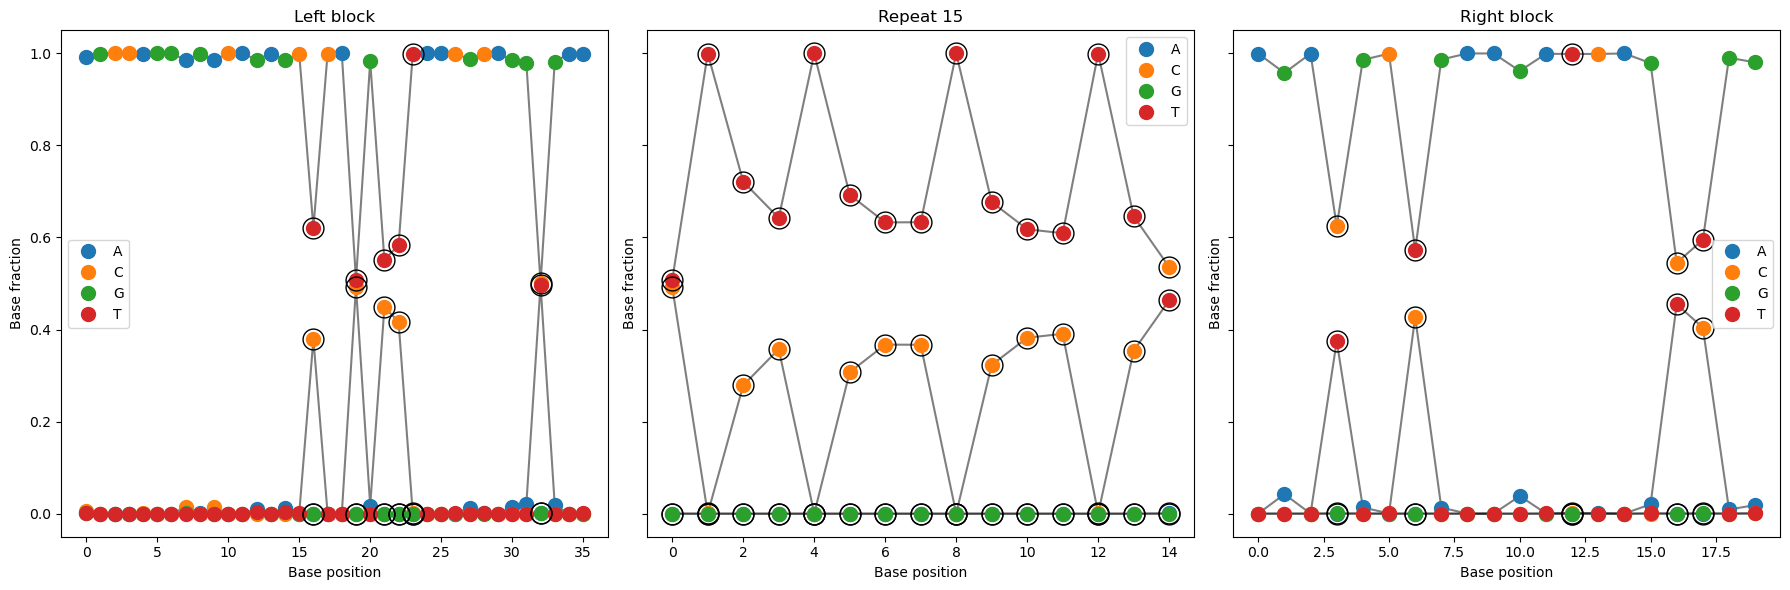

In [9]:
keys = np.sort(list( tables.keys()))

key = keys[3]

df = tables[key]
print(key)
strings = [
"TTGCTTGGTGCTGGTNNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AAAAAAAAAAAAAAA TTCACCTGCG TTAAACATGA GCTCTGTCTC CTGGC",
"TTGCTTGGTGCTGGTNNNNNNNNNNNNNNN CCAACTGXTCTTCAGCATCT AAXAAAXAAAXAAXA TTCACCTGCG TTXAACATGA GCTCTGTCTC CTGGC",
"TTGCTTGGTGCTGGTNNNNNNNNNNNNNNN CCAACTGATCTTCAGCATCT AXAAAXXXAAAXXAA TTCACCTGCG TTAAACATGA GCTCTGTCTCCTGGC"]

strings = [s.replace(" ", "") for s in strings]


from read_break.logic import seq_to_int, BASE2INT, BASES
import numpy as np

expected_left_seq = parser_cfg['params']['r1_seq1'] + parser_cfg['params']['r1_seq2']
expected_right_seq = parser_cfg['params']['r1_seq3']

expected_left_int  = np.array( seq_to_int(expected_left_seq) )
expected_right_int = np.array( seq_to_int(expected_right_seq))


left_block = np.vstack( df.apply(lambda x: np.array( seq_to_int(x["left_block_r1"])), axis=1).values )
right_block = np.vstack( df.apply(lambda x: np.array( seq_to_int(x["right_block_r1"])), axis=1).values )

dfilter = df['repeat_len_r1'] == 15
repeat15 = np.vstack( df[dfilter].apply(lambda x: np.array( seq_to_int(x["repeat_r1"])), axis=1).values )

from read_break.plot import plot_base_totals
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
left_bits = expected_left_int == BASE2INT['T']
right_bits = expected_right_int == BASE2INT['T']
repeat15_bits = np.ones(repeat15.shape[1], dtype=bool)


plot_base_totals(left_block, left_bits, axes[0], small_marker=20, bit_marker=30, marker='.', normed=True)
plot_base_totals(repeat15, repeat15_bits, axes[1], small_marker=20, bit_marker=30, marker='.', normed=True)
plot_base_totals(right_block, right_bits, axes[2], small_marker=20, bit_marker=30, marker='.', normed=True)
axes[0].set_title("Left block")
axes[1].set_title("Repeat 15")
axes[2].set_title("Right block")
for ax in axes:
    ax.set_xlabel("Base position")
    ax.set_ylabel("Base fraction")
plt.tight_layout()

plt.show()


For a basic analysis of mutation data, we typically look for three things:
1. rate of mutation/conversion per position in the read (see above)
2. rate of mutation/conversion per read (across loci)
3. correlation in mutation patterns between positions (neighbor effects).

General library information of interest would include:
1. Proportion of reads that are well formed (from the log of the parser, not currently saved)
2. Number of reads per template using varietal tags (measure of library saturation)
3. Overall count of templates (by varietal tag with rollup), measure of yield.

In [25]:
## we usually have two types of positions: bits and not bits.
## now we have three types: bits, not bits, and methyl-bits.
## that depends on the experiment.

s1 = 'AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAATTTTTTTTTTTTTTTAGATGCTGAAGATCAGTTGGNNNNNNNNNNNNNNNACCAGCACCAAGCAA'
s2 = 'AGCCAGGAGACAGAGCTCATGTTXAACGCAGGTGAATXTTXTTTXTTTXTTAGATGCTGAAGAXCAGTTGGNNNNNNNNNNNNNNNACCAGCACCAAGCAA'
s3 = 'AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAATTXXTTTXXXTTTXTAGATGCTGAAGATCAGTTGGNNNNNNNNNNNNNNNACCAGCACCAAGCAA'

In [30]:


from read_break.logic import reverse_complement
right_block1 = "AGATGCTGAAGATCAGTTGG"
right_block2 = "AGATGCTGAAGAXCAGTTGG"
left_block1  = "AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAA"
left_block2  = "AGCCAGGAGACAGAGCTCATGTTXAACGCAGGTGAA"

middle1 = "T"*15
middle2 = "TXTTXTTTXTTTXTT"
middle3 = "TTXXTTTXXXTTTXT"

In [31]:
expected_blocks = {
"DB1_S3": [left_block1, middle1, right_block1],
"DB2_S4": [left_block1, middle1, right_block1],

"DB3_S5": [left_block2, middle2, right_block2],
"DB4_S6": [left_block2, middle2, right_block2],

"DB5_S7": [left_block1, middle3, right_block1],
"DB6_S8": [left_block1, middle3, right_block1],
}
expected_blocks

{'DB1_S3': ['AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAA',
  'TTTTTTTTTTTTTTT',
  'AGATGCTGAAGATCAGTTGG'],
 'DB2_S4': ['AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAA',
  'TTTTTTTTTTTTTTT',
  'AGATGCTGAAGATCAGTTGG'],
 'DB3_S5': ['AGCCAGGAGACAGAGCTCATGTTXAACGCAGGTGAA',
  'TXTTXTTTXTTTXTT',
  'AGATGCTGAAGAXCAGTTGG'],
 'DB4_S6': ['AGCCAGGAGACAGAGCTCATGTTXAACGCAGGTGAA',
  'TXTTXTTTXTTTXTT',
  'AGATGCTGAAGAXCAGTTGG'],
 'DB5_S7': ['AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAA',
  'TTXXTTTXXXTTTXT',
  'AGATGCTGAAGATCAGTTGG'],
 'DB6_S8': ['AGCCAGGAGACAGAGCTCATGTTTAACGCAGGTGAA',
  'TTXXTTTXXXTTTXT',
  'AGATGCTGAAGATCAGTTGG']}

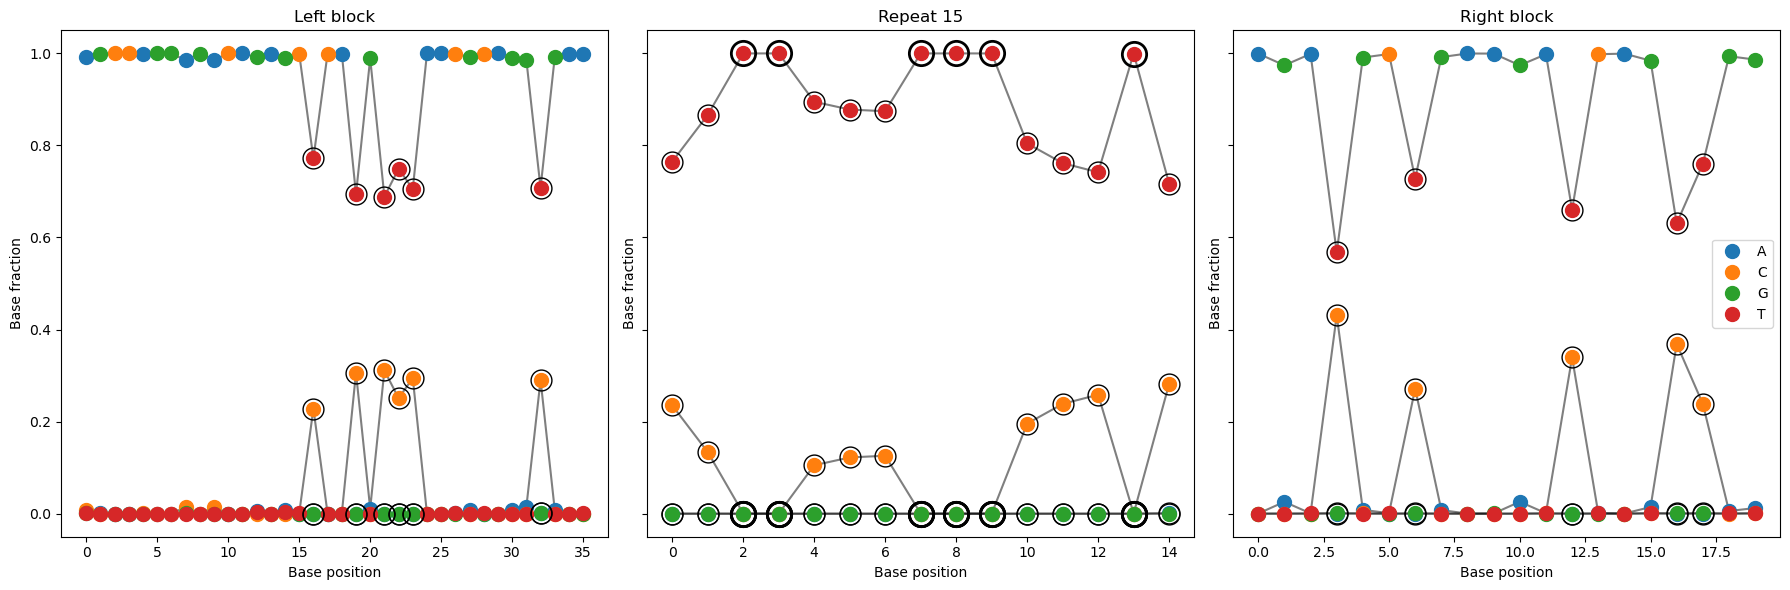

conversion rate for bit positions: 0.25322747560938635
conversion rate for protected positions: 0.0002995560480224462


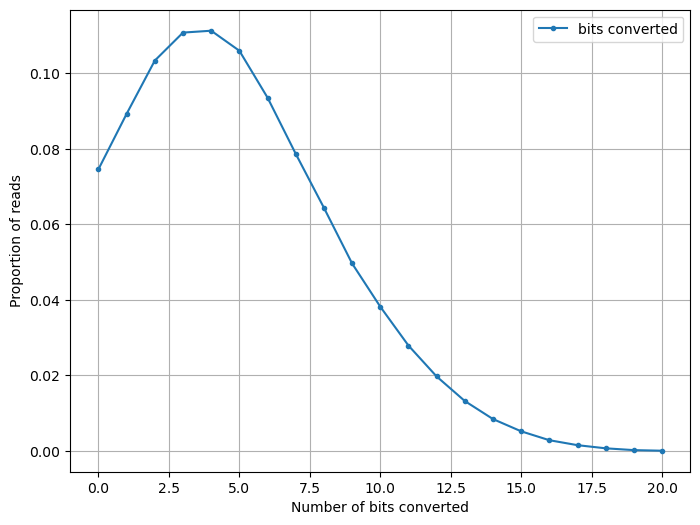

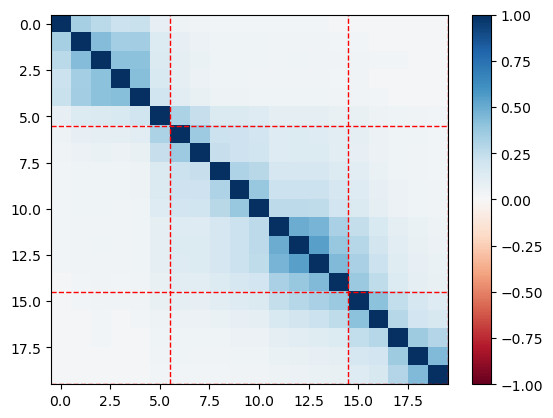

In [121]:
keys = np.sort(list( tables.keys()))

key = keys[5]

df = tables[key]

from read_break.logic import seq_to_int, BASE2INT, BASES
import numpy as np

expected_left_seq = expected_blocks[key][0]
expected_repeat_seq = expected_blocks[key][1]
expected_right_seq = expected_blocks[key][2]



bases = 'ACGTNX'
base2int = {base: i for i, base in enumerate(bases )}

expected_left_int  = np.array( seq_to_int(expected_left_seq, base2int=base2int) )
expected_repeat_int = np.array( seq_to_int(expected_repeat_seq, base2int=base2int))
expected_right_int = np.array( seq_to_int(expected_right_seq, base2int=base2int))






left_block = np.vstack( df.apply(lambda x: np.array( seq_to_int(x["left_block_r1"])), axis=1).values )
right_block = np.vstack( df.apply(lambda x: np.array( seq_to_int(x["right_block_r1"])), axis=1).values )


from read_break.plot import plot_base_totals_only, highlight_base_totals

dfilter = df['repeat_len_r1'] == 15
repeat15 = np.vstack( df[dfilter].apply(lambda x: np.array( seq_to_int(x["repeat_r1"])), axis=1).values )

from read_break.plot import plot_base_totals
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
left_bits = expected_left_int == BASE2INT['T']
right_bits = expected_right_int == BASE2INT['T']
repeat15_bits = expected_repeat_int == BASE2INT['T']

left_protected = expected_left_int == base2int['X']
repeat_protected = expected_repeat_int == base2int['X']
right_protected = expected_right_int == base2int['X']


plot_base_totals_only(left_block , axes[0], marker_size=20, marker='.', draw_sorted_lines=True, normed=True)
plot_base_totals_only(repeat15   , axes[1], marker_size=20, marker='.', draw_sorted_lines=True, normed=True)
plot_base_totals_only(right_block, axes[2], marker_size=20, marker='.', draw_sorted_lines=True, normed=True)

highlight_base_totals(left_block, left_bits, axes[0], marker_size=30, marker='.', normed=True)
highlight_base_totals(repeat15, repeat15_bits, axes[1], marker_size=30, marker='.', normed=True)
highlight_base_totals(right_block, right_bits, axes[2], marker_size=30, marker='.', normed=True)

highlight_base_totals(left_block, left_protected, axes[0], marker_size=35, marker='.', normed=True, mew=2)
highlight_base_totals(repeat15, repeat_protected, axes[1], marker_size=35, marker='.', normed=True, mew=2)
highlight_base_totals(right_block, right_protected, axes[2], marker_size=35, marker='.', normed=True, mew=2)



axes[0].set_title("Left block")
axes[1].set_title("Repeat 15")
axes[2].set_title("Right block")
for ax in axes:
    ax.set_xlabel("Base position")
    ax.set_ylabel("Base fraction")


plt.legend()
plt.tight_layout()

plt.show()


## so now we look by read over the bits and also the protected bits.
dfilter = df['repeat_len_r1'] == 15


base_array    = np.hstack([left_block[dfilter], repeat15, right_block[dfilter]])
all_bits      = np.hstack([left_bits, repeat15_bits, right_bits])
all_protected = np.hstack([left_protected, repeat_protected, right_protected])


bit_lengths = [np.sum(x) for x in [left_bits, repeat15_bits, right_bits]]

bit_positions = np.where(all_bits)[0]
protected_positions = np.where(all_protected)[0]



## compute average mutation rate for bit positions
off_count = base_array[:, bit_positions] == BASE2INT['T']
on_count  = base_array[:, bit_positions] == BASE2INT['C']
on_total = np.sum(on_count)
off_total = np.sum(off_count)
bit_rate = on_total / (on_total + off_total)
print("conversion rate for bit positions:", bit_rate)

off_count_protected = base_array[:, protected_positions] == BASE2INT['T']
on_count_protected  = base_array[:, protected_positions] == BASE2INT['C']
on_total_protected = np.sum(on_count_protected)
off_total_protected = np.sum(off_count_protected)
protected_rate = on_total_protected / (on_total_protected + off_total_protected)
print("conversion rate for protected positions:", protected_rate)

## distribution of mutation rate per read over bit positions:
total_on = np.sum(on_count, axis=1)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
yvals = np.bincount(total_on)
ax1.plot(yvals / np.sum(yvals), '.-', label="bits converted")
ax1.grid()
ax1.set_xlabel("Number of bits converted")
ax1.set_ylabel("Proportion of reads")
ax1.legend()

## lastly we examine the correlation of bit positions

base_array_bits_only = base_array[:, all_bits]
bit_correlation = np.corrcoef(base_array_bits_only, rowvar=False)

plt.figure()
plt.imshow(bit_correlation, interpolation='nearest', aspect='auto', vmin=-1, vmax=1, cmap='RdBu')
for i in np.cumsum(bit_lengths):
    plt.axvline(i -0.5, color='red', lw=1, ls='--')
    plt.axhline(i -0.5, color='red', lw=1, ls='--')
plt.colorbar()

In [ ]:
print(bit_lengths)


[np.int64(5), np.int64(11), np.int64(4)]


array([ 5, 16, 20])

In [ ]:


plt.plot(np.bincount(total_on), label="on")
plt.grid()
plt.show()


# from collections import Counter
# Counter(zip(center_bit_on, center_bit_off) )

# #left_block[:, left_protected] == BASE2INT['T']

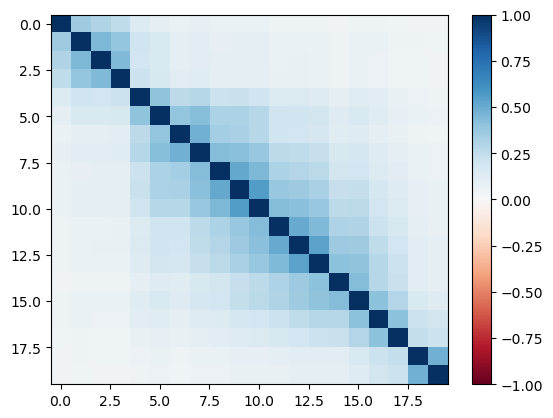

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(71, 71))

In [ ]:
from pathlib import Path
from functools import cache
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from read_break.logic import seq_to_int, BASE2INT           # existing utilities
from read_break.plot import plot_base_totals_only, highlight_base_totals

BASES = "ACGTNX"
BASE2INT_FAST = {b: i for i, b in enumerate(BASES)}

@cache
def seq_to_arr(seq: str, mapper=BASE2INT_FAST) -> np.ndarray:
    """Vectorised wrapper with LRU-cache (avoids re-parsing identical sequences)."""
    return np.fromiter((mapper[b] for b in seq), dtype="int8")


def prepare_arrays(sample: str,
                   tables: dict[str, pd.DataFrame],
                   expected_blocks: dict[str, tuple[str, str, str]],
                   repeat_len: int = 15):
    """Return all arrays & masks needed by the plotting routines."""
    df = tables[sample]

    # ------------------------------------------------------------------ expected motifs
    left_seq, repeat_seq, right_seq = expected_blocks[sample]
    exp_left, exp_rep, exp_right = map(seq_to_arr, (left_seq, repeat_seq, right_seq))
    

    left_bits   = exp_left  == BASE2INT_FAST['T']
    repeat_bits = exp_rep   == BASE2INT_FAST['T']
    right_bits  = exp_right == BASE2INT_FAST['T']

    left_prot   = exp_left  == BASE2INT_FAST['X']
    repeat_prot = exp_rep   == BASE2INT_FAST['X']
    right_prot  = exp_right == BASE2INT_FAST['X']

    # ------------------------------------------------------------------ reads → int arrays
    to_arr = lambda col: np.vstack(df[col].map(seq_to_arr))
    left_block  = to_arr("left_block_r1")
    right_block = to_arr("right_block_r1")

    dfilter     = df["repeat_len_r1"].eq(repeat_len)
    repeat15    = np.vstack(df[dfilter]["repeat_r1"].map(seq_to_arr))

    # ------------------------------------------------------------------ aggregate arrays
    all_bits      = np.hstack([left_bits, repeat_bits, right_bits])
    all_protected = np.hstack([left_prot, repeat_prot, right_prot])
    all_expected = np.hstack([exp_left, exp_rep, exp_right])    

    base_array    = np.hstack([left_block[dfilter], repeat15, right_block[dfilter]])

    bit_lengths   = [left_bits.sum(), repeat_bits.sum(), right_bits.sum()]

    return (left_block, repeat15, right_block,
            left_bits, repeat_bits, right_bits,
            left_prot, repeat_prot, right_prot,
            base_array, all_bits, all_protected, all_expected, bit_lengths)


def plot_library(sample: str,
                 tables: dict[str, pd.DataFrame],
                 expected_blocks: dict[str, tuple[str, str, str]],
                 figsize: tuple[int, int] = (15, 10)) -> plt.Figure:
    """
    2 × 3 layout

        ┌──────────┬────────────┬───────────┐
        │ left     │ repeat 15  │ right     │   (base-fraction scatter plots)
        ├──────────┼────────────┼───────────┤
        │ bits/rd  │ corr-matrix│  stats    │   (metrics row — square heat-map + text panel)
        └──────────┴────────────┴───────────┘
    """
    # ── data wrangling ────────────────────────────────────────────────────────────
    (left_block, repeat15, right_block,
     left_bits, repeat_bits, right_bits,
     left_prot, repeat_prot, right_prot,
     base_array, all_bits, all_protected, 
     all_expected, bit_lengths) = prepare_arrays(sample, tables, expected_blocks)

    # ── figure + grid spec ────────────────────────────────────────────────────────
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    gs  = GridSpec(2, 3, figure=fig, height_ratios=[1, 1.1])

    ax_left   = fig.add_subplot(gs[1, 0])
    ax_rep    = fig.add_subplot(gs[1, 1])
    ax_right  = fig.add_subplot(gs[1, 2])
    ax_dist   = fig.add_subplot(gs[0, 1])
    ax_corr   = fig.add_subplot(gs[0, 2])   #  ← one cell only → square
    ax_stats  = fig.add_subplot(gs[0, 0])
    ax_stats.axis("off")                    # text-only panel

    # ── (row 0) base-fraction scatter plots ──────────────────────────────────────
    for block, ax, bits, prot, title in [
        (left_block,  ax_left,  left_bits,  left_prot,  "Left block"),
        (repeat15,    ax_rep,   repeat_bits,repeat_prot,"Repeat len 15"),
        (right_block, ax_right, right_bits, right_prot, "Right block")]:
        plot_base_totals_only(block, ax, marker_size=20, marker='.', normed=True,
                              draw_sorted_lines=True)
        highlight_base_totals(block, bits,  ax, marker_size=20, marker='.', normed=True, label='convertable')
        highlight_base_totals(block, prot,  ax, marker_size=30, marker='.', normed=True, label = 'protected', mew=2, mec='gold')
        ax.set_title(title)
        ax.set_xlabel("Base position")
        ax.set_ylabel("Base fraction")

    handles, labels = ax_left.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))          # keeps last occurrence
    ax_left.legend(uniq.values(), uniq.keys(), loc='center left')

    # ── (row 1 - col 0) distribution of bits-on per read ─────────────────────────
    on_bits = base_array[:, all_bits] == BASE2INT['C']
    n_on    = on_bits.sum(axis=1)
    n_bits_tot = all_bits.sum()                         # for bin edges
    bins = np.arange(-0.5, n_bits_tot + 1.5, 1)         # centred on integers

    ax_dist.hist(
        n_on,
        bins=bins,
        density=True,           #  → proportion, not raw counts
        histtype="bar",
        edgecolor="black",
        label="bits converted",
    )

    ax_dist.set_xlabel("Number of bits converted")
    ax_dist.set_ylabel("Proportion of reads")
    ax_dist.grid()
    ax_dist.legend()

    # ── (row 1 - col 1) square bit-correlation matrix ────────────────────────────
    bit_corr = np.corrcoef(base_array[:, all_bits], rowvar=False)
    im = ax_corr.imshow(bit_corr, interpolation='nearest', vmin=-1, vmax=1,
                        cmap='RdBu', aspect='equal')   # <- square
    for i in np.cumsum(bit_lengths):
        ax_corr.axvline(i - .5, color='red', lw=1, ls='--')
        ax_corr.axhline(i - .5, color='red', lw=1, ls='--')
    ax_corr.set_title("Bit-to-bit correlation")
    fig.colorbar(im, ax=ax_corr, fraction=.045)

    # ── (row 1 - col 2) numeric summary ──────────────────────────────────────────
    # -- global counts -----------------------------------------------------------
    n_reads = base_array.shape[0]

    # -- bit conversion ----------------------------------------------------------
    off_bits = base_array[:, all_bits] == BASE2INT['T']
    bit_rate = on_bits.sum() / (on_bits.sum() + off_bits.sum())

    # -- protected conversion ----------------------------------------------------
    prot_pos = np.where(all_protected)[0]
    on_prot  = (base_array[:, prot_pos] == BASE2INT['C']).sum()
    off_prot = (base_array[:, prot_pos] == BASE2INT['T']).sum()
    prot_rate = np.nan if (on_prot + off_prot) == 0 else on_prot / (on_prot + off_prot)

    # -- “other” error rate ------------------------------------------------------
    other_pos     = ~all_bits & ~all_protected
    observed_other = base_array  [:, other_pos]
    expected_other = all_expected[other_pos]
    mismatches = (observed_other != expected_other).sum()
    total_other = observed_other.size
    err_rate = np.nan if total_other == 0 else mismatches / total_other

    txt = (
        f"Reads analysed:\n"
        f"  {n_reads:,}\n\n"
        f"Average conversion (bits):\n"
        f"  {bit_rate:.2%}\n\n"
        f"Average conversion (protected):\n"
        f"  {prot_rate:.2%}\n\n"
        f"Average error (other bases):\n"
        f"  {err_rate:.2%}"
    )
    ax_stats.text(0, 0.95, txt, va='top', ha='left', fontsize=11,
                  family='monospace', transform=ax_stats.transAxes)

    # ── tidy up ──────────────────────────────────────────────────────────────────
    fig.suptitle(f"Library {sample}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig


In [175]:
tables
print(tables.keys())



dict_keys(['DB1_S3', 'DB2_S4', 'DB3_S5', 'DB4_S6', 'DB5_S7', 'DB6_S8'])


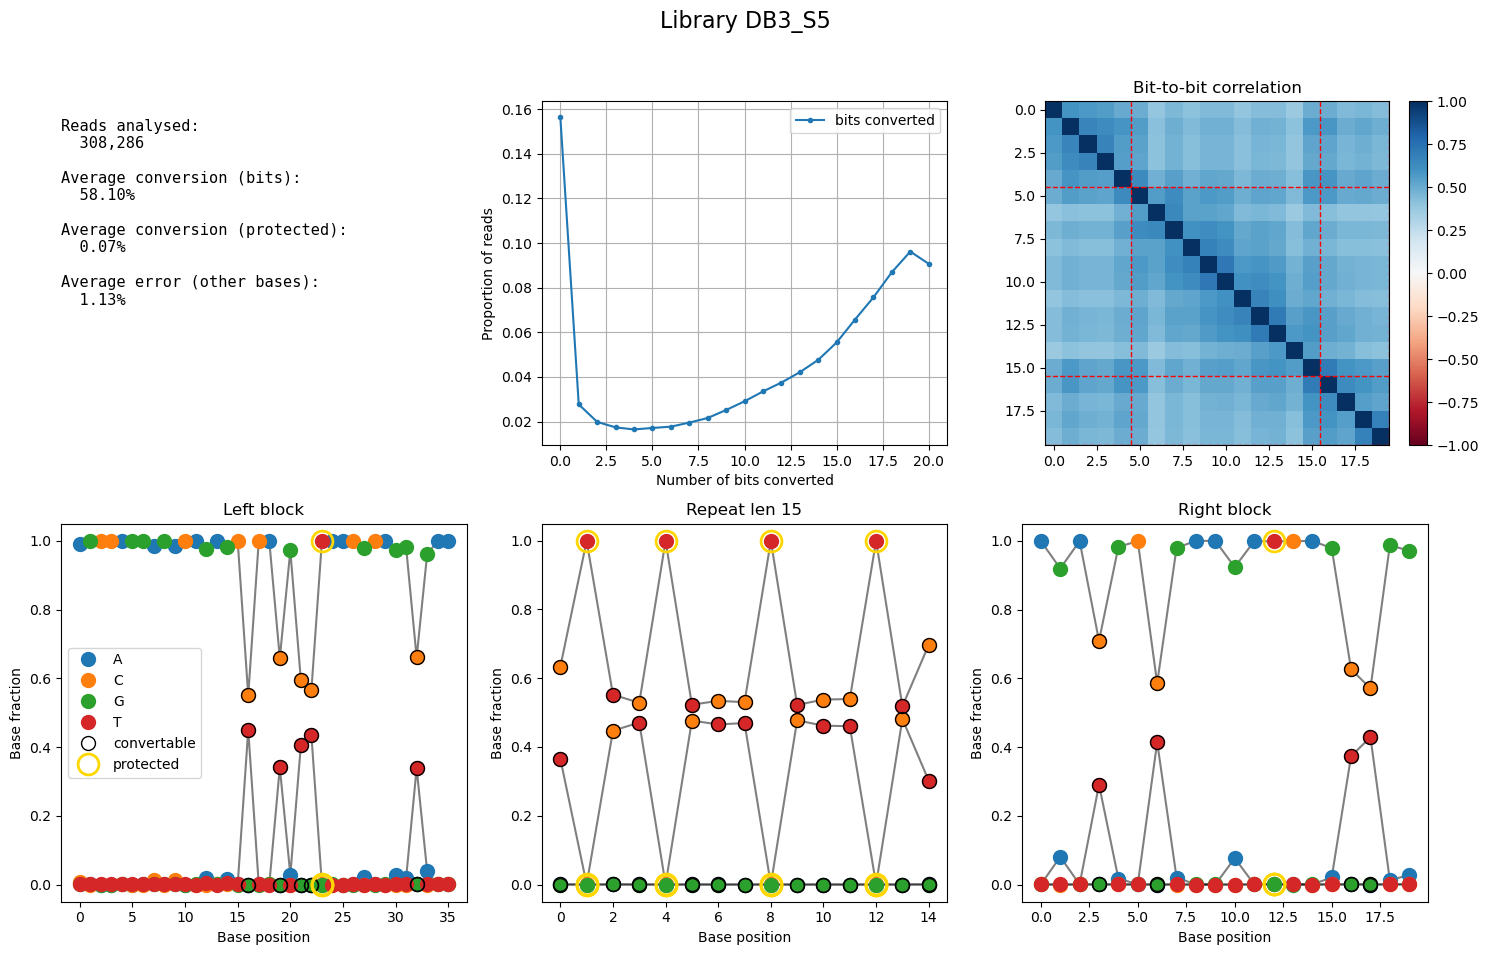

In [176]:

sample = 'DB3_S5'
fig = plot_library(sample, tables, expected_blocks)
plt.show()

In [177]:
from matplotlib.backends.backend_pdf import PdfPages

output_pdf = Path("library_plots_2.pdf")

with PdfPages(output_pdf) as pdf:
    for sample in sorted(tables):
        fig = plot_library(sample, tables, expected_blocks)
        pdf.savefig(fig)
        plt.close(fig)

print("✓ PDF written:", output_pdf.resolve())


✓ PDF written: C:\Users\levy\Repos\read-break\notebooks\library_plots_2.pdf
